In [1]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

# Replace this to use Noisy QLSTM
# from QLSTM_Noisy import SequenceDataset
from QODE import SequenceDataset

import yfinance as yf
from pandas_datareader import data as pdr


In [2]:
# df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')
df = pd.read_csv('./irregularly_sampled_data.csv')

In [3]:
columns = ['Open', 'High', 'Low', 'Close']

In [4]:
data = df.filter(columns)
dataset = data.values

In [5]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [6]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'

In [7]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [8]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [9]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [10]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        # Ensure proper dimensions
        if len(X.shape) == 2:
            X = X.unsqueeze(0)  # Add batch dimension
        
        output = model(X)
        
        # Ensure output and target have same dimensions
        if len(output.shape) != len(y.shape):
            output = output.squeeze()
        
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            # Ensure proper dimensions
            if len(X.shape) == 2:
                X = X.unsqueeze(0)
            
            output = model(X)
            
            # Ensure output and target have same dimensions
            if len(output.shape) != len(y.shape):
                output = output.squeeze()
            
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [11]:
# from QODE import ShallowRegressionPeepholeLSTM

# learning_rate = 0.01
# num_hidden_units = 16

# Qmodel = ShallowRegressionPeepholeLSTM(
#     num_sensors=len(features), 
#     hidden_units=num_hidden_units, 
#     # n_qubits=7,
#     # n_qlayers=1
# )
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

In [12]:
from QODE import ShallowRegressionPeepholeLSTM

In [13]:
from QODE import ShallowRegressionQuantumODELSTM

In [27]:
from QODE import ShallowRegressionQuantumODELSTM
learning_rate = 0.01
num_hidden_units = 16

Qmodel = ShallowRegressionQuantumODELSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=18,
    num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

In [28]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 3249


In [29]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.009713184304512696
Test loss: 0.0018638475512777824
Execution time 176.01579403877258
Epoch 1
---------
Train loss: 0.001368184934641144
Test loss: 0.000305371466185684
Execution time 157.91710710525513
Epoch 2
---------
Train loss: 0.00038125518846091224
Test loss: 0.0003363358629564847
Execution time 312.8710563182831
Epoch 3
---------
Train loss: 0.0004896988841041469
Test loss: 0.000247960975366103
Execution time 154.2526593208313
Epoch 4
---------
Train loss: 0.0005868060725606493
Test loss: 0.0003011979877850001
Execution time 147.76859712600708
Epoch 5
---------
Train loss: 0.0003203538656603597
Test loss: 0.0001559548003790078
Execution time 147.82719707489014
Epoch 6
---------
Train loss: 0.0002840342719535601
Test loss: 0.00028672907419306846
Execution time 147.97997879981995
Epoch 7
---------
Train loss: 0.00033675602574860584
Test loss: 8.895076277146096e-05
Execution time 238.9407205581665
Epoch 8
---------
Train loss

In [30]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

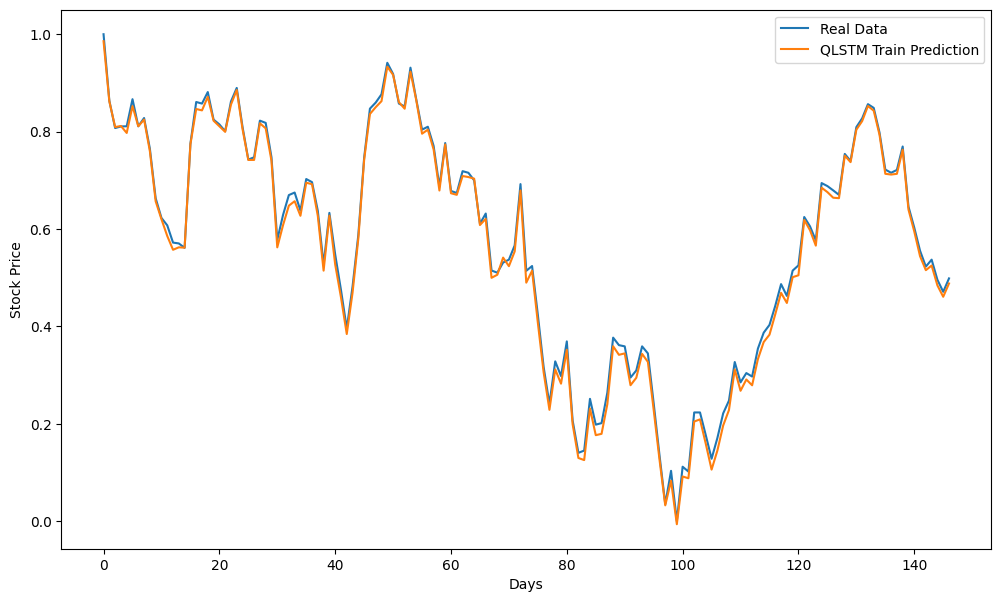

In [31]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["Close"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

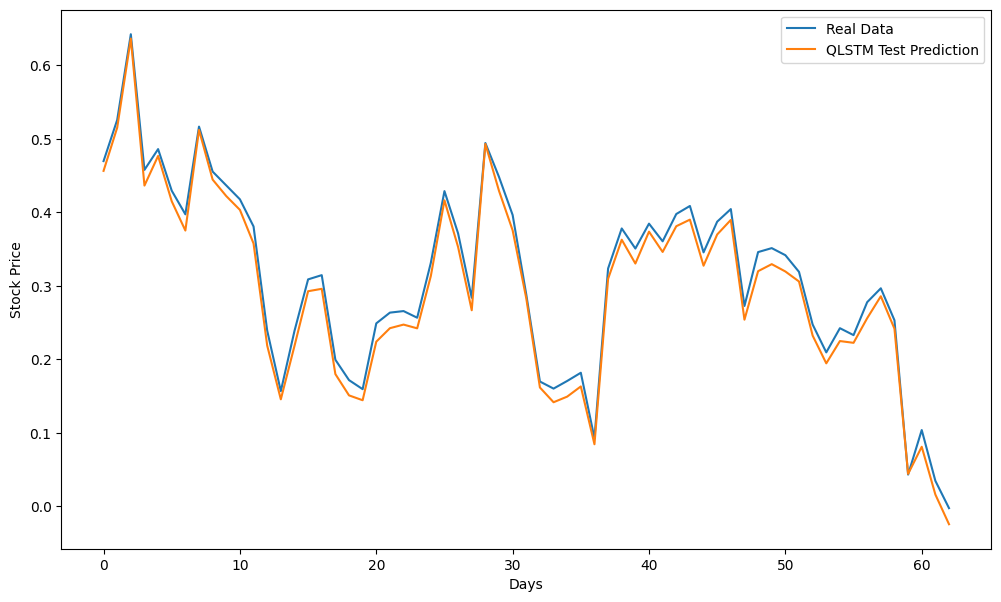

In [32]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Close"], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "QLSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend() 
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

# Calculate metrics for train data
train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
train_mae = mean_absolute_error(df_train["Close"], df_train["Model Forecast"])
# Avoid division by zero in MAPE calculation
train_mape = np.mean(np.abs((df_train["Close"] - df_train["Model Forecast"]) / np.maximum(np.abs(df_train["Close"]), 1e-10))) * 100

# Calculate metrics for test data
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
test_mae = mean_absolute_error(df_test["Close"], df_test["Model Forecast"])
# Avoid division by zero in MAPE calculation
test_mape = np.mean(np.abs((df_test["Close"] - df_test["Model Forecast"]) / np.maximum(np.abs(df_test["Close"]), 1e-10))) * 100

# Print all metrics
print("Training Data Metrics:")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"MAPE: {train_mape:.2f}%")
print("\nTest Data Metrics:")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

Training Data Metrics:
RMSE: 0.0127
MAE: 0.0109
MAPE: 42609417.38%

Test Data Metrics:
RMSE: 0.0168
MAE: 0.0159
MAPE: 20.34%


Training Data Metrics:
RMSE: 0.0074
MAE: 0.0058
MAPE: 72237680.96%

Test Data Metrics:
RMSE: 0.0107
MAE: 0.0082
MAPE: 70.62%

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

# Calculate metrics for train data
train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
train_mae = mean_absolute_error(df_train["Close"], df_train["Model Forecast"])
# Avoid division by zero in MAPE calculation
train_mape = np.mean(np.abs((df_train["Close"] - df_train["Model Forecast"]) / np.maximum(np.abs(df_train["Close"]), 1e-10))) * 100

# Calculate metrics for test data
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
test_mae = mean_absolute_error(df_test["Close"], df_test["Model Forecast"])
# Avoid division by zero in MAPE calculation
test_mape = np.mean(np.abs((df_test["Close"] - df_test["Model Forecast"]) / np.maximum(np.abs(df_test["Close"]), 1e-10))) * 100

# Print all metrics
print("Training Data Metrics:")
print(f"RMSE: {train_rmse:.6f}")
print(f"MAE: {train_mae:.4f}")
print(f"MAPE: {train_mape:.2f}%")
print("\nTest Data Metrics:")
print(f"RMSE: {test_rmse:.6f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.2f}%")

Training Data Metrics:
RMSE: 0.012652
MAE: 0.0109
MAPE: 42609417.38%

Test Data Metrics:
RMSE: 0.016818
MAE: 0.0159
MAPE: 20.34%


In [35]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 1.0
Test accuracy: 1.0


In [36]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")

In [23]:
import yfinance as yf

# High-frequency trading data
symbols = ['BTC-USD', 'ETH-USD', 'AAPL', 'GOOGL']
interval = '30m'  # 1-minute data
period = '7d'    # Last 7 days

data = {}
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    data[symbol] = ticker.history(period=period, interval=interval)

In [24]:
type(data)

dict

In [25]:
import pandas as pd

In [26]:
df = pd.DataFrame(data)

print(df)

ValueError: If using all scalar values, you must pass an index